In [4]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
import string
import re
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
from collections import Counter
import regex
from nltk import pos_tag
from nltk.tokenize import sent_tokenize
from tqdm.notebook import tqdm
tqdm.pandas()

In [5]:
def convert_emojis(text):
    """remove emojis from text"""
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, " ")
    return text# Example

def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = re.sub( emot, " "+("_".join( EMOTICONS_EMO[emot].replace(",","").split()) ), text )
    return text# Example

In [6]:
df= pd.read_csv('Suicide_Detection.csv', index_col=False)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
df['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

In [8]:
#convert class into 1==suicide, 0==non-suicide for classification task later on
df['class']= df['class'].apply(lambda x : 1 if x=='suicide' else 0)

# Text Cleaning

In [10]:
#lower text
df['text']= df['text'].progress_apply(lambda x: x.lower())

  0%|          | 0/232074 [00:00<?, ?it/s]

In [11]:
#remove emojis
df['text_emoji']= df['text'].progress_apply(lambda x: convert_emojis(x))

  0%|          | 0/232074 [00:00<?, ?it/s]

In [12]:
#remove links
df['text_emoji']= df['text_emoji'].progress_apply(lambda x: regex.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})[^\s]+',"",x))

  0%|          | 0/232074 [00:00<?, ?it/s]

In [14]:
# remove "filer" in all its forms
df['text_emoji']= df['text_emoji'].progress_apply(lambda x: regex.sub('fil{2,}er',"",x))

  0%|          | 0/232074 [00:00<?, ?it/s]

In [15]:
# remove "fier" in all its forms
df['text_emoji']= df['text_emoji'].progress_apply(lambda x: regex.sub('(fier)+',"",x))

  0%|          | 0/232074 [00:00<?, ?it/s]

In [16]:
#tokenize text
df['token']=df['text_emoji'].progress_apply(lambda x: word_tokenize(x))

  0%|          | 0/232074 [00:00<?, ?it/s]

In [17]:
#remove stopwords
stopwords= set(nltk.corpus.stopwords.words('english'))
stopwords.add('im')
df['token_clean']= df['token'].progress_apply(lambda x: [i for i in x if i not in stopwords])

  0%|          | 0/232074 [00:00<?, ?it/s]

In [20]:
#stringifiy
df['text_clean']= df['token_clean'].progress_apply(lambda x: " ".join(x))

  0%|          | 0/232074 [00:00<?, ?it/s]

In [21]:
#remove numbers
df['text_clean']= df['text_clean'].progress_apply(lambda x: regex.sub('\d+',"",x))

  0%|          | 0/232074 [00:00<?, ?it/s]

In [22]:
#remove punctuation
pun= string.punctuation
pun+='’”“'
df['text_clean']=df['text_clean'].progress_apply( lambda x: x.translate(str.maketrans('', '', string.punctuation)) )

  0%|          | 0/232074 [00:00<?, ?it/s]

In [23]:
#tokenize (again)
df['token2']=df['text_clean'].progress_apply(lambda x: word_tokenize(x))

  0%|          | 0/232074 [00:00<?, ?it/s]

In [24]:
#lemmetize tokens
from nltk.stem import WordNetLemmatizer
#from nltk.stem import PorterStemmer
lemme= WordNetLemmatizer()
#ps= PorterStemmer()
df['token2']= df['token2'].progress_apply(lambda x: [lemme.lemmatize(i) for i in x])

  0%|          | 0/232074 [00:00<?, ?it/s]

In [25]:
#remove any token with 2 letters or below
df['token2']= df['token2'].progress_apply(lambda x: [i for i in x if len(i)>2])

  0%|          | 0/232074 [00:00<?, ?it/s]

In [26]:
#stringifiy
df['text2']= df['token2'].progress_apply(lambda x: ' '.join(x))

  0%|          | 0/232074 [00:00<?, ?it/s]

In [27]:
#test 
#df['text3']=df['text2'].progress_apply(lambda x: regex.sub('(beer)|(iti)|(slp)|(hay)|(suer)|(want)|(dont)|(toi)|(lifei)|(donei)|(helpi)|(mei)|(wan)',"",x))

  0%|          | 0/232074 [00:00<?, ?it/s]

# Topic Modeling LSA

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer 

In [64]:
#use CountVectorizer and TfidfVectorizer to convert text into a matrix representation 
vectorizer = CountVectorizer()
doc_word = vectorizer.fit_transform(df['text2'])

tf= TfidfVectorizer()
tfidf= tf.fit_transform(df['text2'])

(232074, 154157)

In [66]:
#Train two LSA model on one using count vectorizer and the other uses tfidf
n_com=2
svd = TruncatedSVD(n_components=n_com, random_state=42)
t= svd.fit_transform(tfidf)

svd2 = TruncatedSVD(n_components=n_com, random_state=42)
t2= svd2.fit_transform(doc_word)

In [70]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    """display topics and the group of words that repreasent that topic"""
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

## Count Vectorizer

In [71]:
num=100
#model trained using Count Vectorizer
display_topics(svd2, vectorizer.get_feature_names(), num)


Topic  0
fuck, jake, paul, shit, like, get, want, life, fucking, know, feel, time, even, people, one, would, year, friend, day, thing, never, really, think, going, make, much, could, got, school, way, everything, talk, back, still, hate, say, anything, nothing, good, thought, help, care, every, always, see, love, better, someone, anymore, something, die, family, work, ever, right, live, end, everyone, mom, job, take, need, give, tell, kill, parent, told, person, anyone, feeling, head, point, month, said, bad, around, made, try, keep, world, last, girl, since, well, done, long, suicide, tried, dont, money, getting, wanted, away, maybe, happy, trying, also, started, enough, week

Topic  1
cheese, stop, pretty, cool, like, get, day, know, one, want, time, thing, make, sus, grilled, life, really, even, would, love, right, feel, good, got, well, friend, think, bread, people, going, year, much, way, mom, never, see, say, back, help, work, step, butter, eat, look, something, could, said, tak

## tfidf Vectorizer

In [72]:
#model trained using tfidf Vectorizer
display_topics(svd, tf.get_feature_names(), num)


Topic  0
want, like, feel, know, life, get, friend, time, people, would, even, really, one, year, thing, think, day, going, never, help, make, much, anymore, could, fucking, thought, someone, anything, way, talk, die, need, school, better, good, everything, end, love, nothing, hate, kill, family, anyone, always, say, care, see, live, got, still, something, back, every, feeling, suicide, everyone, right, work, ever, shit, keep, take, tell, parent, last, dont, bad, happy, point, person, job, month, since, try, tired, tried, told, reason, pain, getting, girl, hurt, alone, long, around, wish, fuck, suicidal, away, find, else, trying, lot, stop, week, said, made, give, depression, also

Topic  1
want, die, feel, anymore, kill, fucking, hate, life, dont, tired, live, pain, anyone, please, someone, end, talk, hurt, care, know, stop, wish, cant, wan, alive, nothing, everything, bored, anything, living, scared, alone, diei, help, world, deserve, anymorei, need, death, nobody, dead, myselfi, ke

## Comments:  
We can see that using the tfidf Vectorizer gives better results than Count Vectorizer, this could be due to the fact that tfidf punishes the most frequent words between all docs. Also notice how all the words in Topic 1 under the tfidf Vectorizer section have words that convey certin emotions such as: a cry for help, the future is meek, life would be better without them, stopping the pain by any mean, etc... .

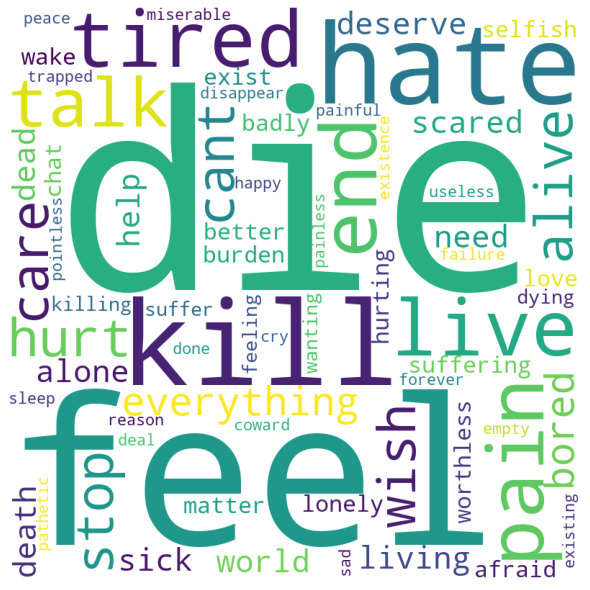

In [129]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


word=""" die, feel, kill, hate, tired, live, pain, 
end, talk, hurt, care, stop, wish, cant, alive, everything, bored, living, scared, alone, die, help, 
world, deserve, need, death, dead, sick, suffering, selfish, chat, burden, exist, worthless, wake, 
lonely, hurting, matter, better, love, badly, afraid, killing, dying, suffer, feeling, wanting, 
disappear, miserable, empty, painful, sad, reason, useless, coward, existing, painless, cry, peace, done, 
trapped, forever, existence, sleep, happy, failure, pathetic, deal, pointless"""

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(word)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('pic.png')
plt.show()



### these are the words from topic 1 under the tfidf Vectorizer section

# Classification Model

In [61]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

In [62]:
x=df['text2']
y=df['class']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

model=Pipeline( [ ('tfidf', TfidfVectorizer()),
                  ('clf', MultinomialNB())] )

model.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [63]:
pred = model.predict(x_test)

In [64]:
print(confusion_matrix(y_test, pred))

[[27778  7046]
 [  882 33917]]


In [65]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88     34824
           1       0.83      0.97      0.90     34799

    accuracy                           0.89     69623
   macro avg       0.90      0.89      0.89     69623
weighted avg       0.90      0.89      0.89     69623



## Comments:  
For this classifier Recall will be the most important metric since the penalty of classifing someone who has suicidal thouts as non-suicidal is dangerous. As we can see the model achived 97% recall for class 1 (Suicidal)

In [57]:
import plotly.express as px
from sklearn.metrics import precision_recall_curve, auc, recall_score
y_score = pred

precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (recall for Suicidal class={recall_score(y_test, y_score):.2f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

# Conclusion

Topic modeling: The emotions/words used by people with suicidal thoughts are usually are about being lost, self loathing, ending the pain, despair, etc... .

Classifier: Recall is the most important measure to focus on since the penalty of missclassifing someone as not having suicidel thoughts will prevent help from reaching them before its too late.